In [74]:
from functions_v2 import*
from methods import MethodFinder

import brightway2 as bw
import bw2data as bd
import bw2analyzer as ba

#reduce?
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bd.projects.set_current("premise-validation-try1")
bw.bw2setup()

bio3=bw.Database('biosphere3')
ei39=bw.Database('ecoinvent 3.9.1 cutoff')
ei39SSP2=bw.Database('ei_cutoff_3.9_image_SSP2-RCP19_2050 2024-06-27')

Biosphere database already present!!! No setup is needed


In [2]:
#Get 5 sectors from 5 yaml files and run LCA scores to plot lvl 1 plot. Save each method in a different sheet.

In [99]:
#sector filters file names/paths

cement = 'cement_small.yaml'
electricity = 'electricity_small.yaml'
fuels= 'fuels_small.yaml'
steel = 'steel_small.yaml'
transport = 'transport_small.yaml'

In [48]:
files = [cement, electricity, fuels, steel, transport]

In [100]:
files_dict={}
files_dict['cement']={'yaml': 'yamls\cement_small.yaml'}
files_dict['electricity']= {'yaml':'yamls\electricity_small.yaml'}

In [65]:
print(os.getcwd())

c:\Users\fried\premise_validation\dev


In [85]:
files_dict

{'cement': {'yaml': 'yamls\\cement_small.yaml'},
 'electricity': {'yaml': 'yamls\\electricity_small.yaml'}}

In [80]:
files_dict['cement']['yaml']

'yamls\\cement_small.yaml'

In [107]:
#Get Methods
finder=MethodFinder()
finder.find_and_create_method(criteria=['IPCC', '2013', 'GWP100'], exclude=['no LT'])
# finder.find_and_create_method(criteria=['EN15804','Cumulative', 'non-renewable' ])
# finder.find_and_create_method(criteria=['land occupation','selected'])
# finder.find_and_create_method(criteria=['EN15804','fresh water'])
method_dict=finder.get_all_methods()
method_dict

{'method_1': {'object': Brightway2 Method: IPCC 2013: climate change: global warming potential (GWP100),
  'method name': ('IPCC 2013',
   'climate change',
   'global warming potential (GWP100)'),
  'short name': 'global warming potential (GWP100)',
  'unit': 'kg CO2-Eq'}}

In [86]:
generate_sets_from_filters(files_dict['cement']['yaml'], database=ei39SSP2)

{'Cement': {'cement production, Portland' (kilogram, US, None),
  'cement production, Portland' (kilogram, PE, None),
  'cement production, Portland' (kilogram, ZA, None),
  'cement production, Portland' (kilogram, BR, None),
  'cement production, Portland' (kilogram, CH, None),
  'cement production, Portland' (kilogram, IN, None),
  'cement production, Portland' (kilogram, CA-QC, None)}}

In [101]:
generate_sets_from_filters(files_dict['electricity']['yaml'], database=ei39SSP2)

{'Electricity': {'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, TUR, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, CHN, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, USA, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, BRA, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, RSAM, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, UKR, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, SAF, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, RUS, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, CEU, None),
  'electricity production, at biomass-fired IGCC power plant' (kilowatt hour, KOR, None)}}

Omitting activity name common prefix: 'cement production, '


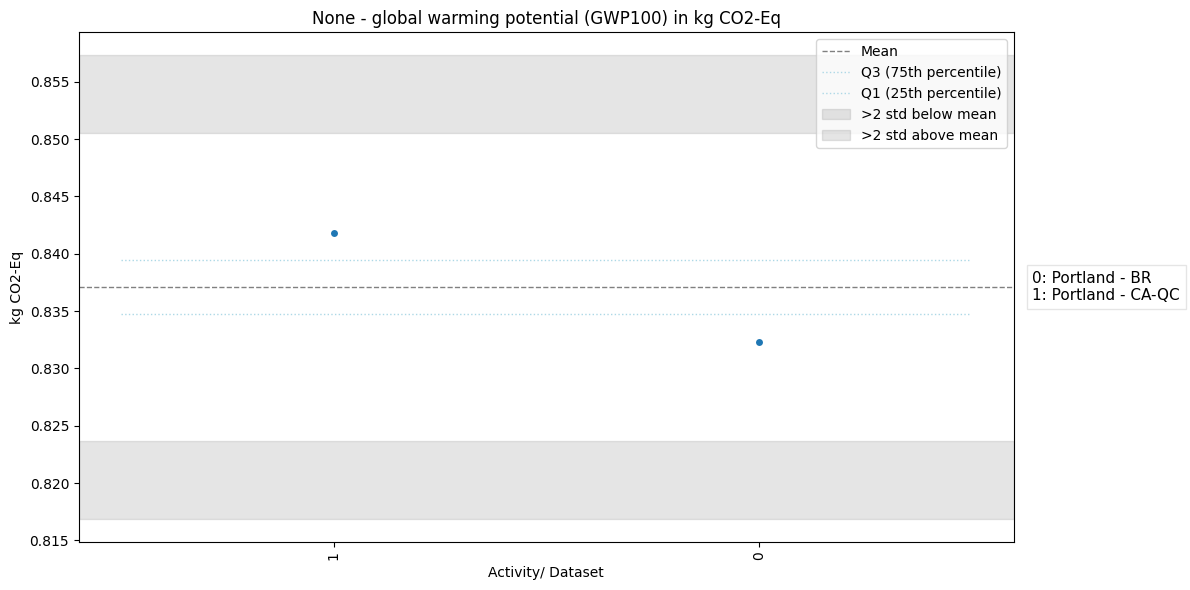

Omitting activity name common prefix: 'electricity production, at biomass-fired IGCC power '


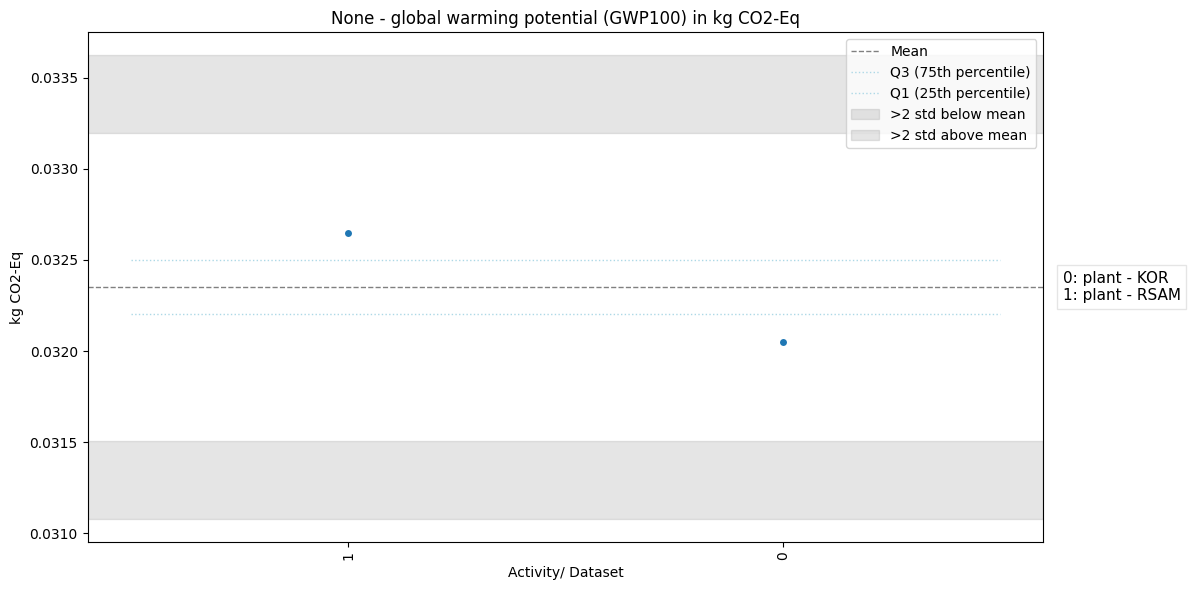

In [111]:
for key, value in files_dict.items():
    yaml_file=value['yaml']
    set=generate_sets_from_filters(yaml_file, database=ei39SSP2)
    set=[x for x in set[key.capitalize()]] #database is an argument
    set=set[:2]

    lca_scores=compare_activities_multiple_methods(
        activities_list=set,
        methods=method_dict,
        identifier=None,
        output_format='pandas',
        mode='absolute'
    )

    lca_scores_agg=small_inputs_to_other_column(lca_scores, cutoff=0.02)

    lvl1_plot(lca_scores_agg)


In [125]:
lca_scores_agg[key]

,activity,product,location,unit,method,method unit,total,direct emissions,8614: Support and operation services to forestry and logging,6511: Road transport services of freight,"12020: Natural gas, liquefied or in the gaseous state",88311: Wood manufacturing services,other
1,plant,,RSAM,kilowatt hour,global warming potential (GWP100),kg CO2-Eq,0.032650,0.006119,0.012793,0.007180,0.000000,0.000967,0.002576
0,plant,,KOR,kilowatt hour,global warming potential (GWP100),kg CO2-Eq,0.032052,0.005984,0.012511,0.007021,0.001147,0.000946,0.002135


In [126]:
df=pd.DataFrame(lca_scores_agg[key])

In [127]:
output_file = 'output.xlsx'
df.to_excel(output_file, index=False, engine='openpyxl')

In [147]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.chart import BarChart, Reference
from openpyxl.chart import BarChart, Reference

# Assuming you have a DataFrame called 'df' with a column named 'total'
# If not, replace 'df' with your actual DataFrame name

# Step 1: Save the DataFrame to an Excel file
excel_file = 'data.xlsx'
df.to_excel(excel_file, index=False)

# Step 2: Use openpyxl to create the bar chart
wb = load_workbook(excel_file)
ws = wb.active

# Determine the number of rows in the worksheet
row_count = ws.max_row

# Create the bar chart
chart = BarChart() #actually want a dot plot! and add mean and iqr range and std 
chart.type = "col"
chart.style = 10
chart.title = "LCA Scores" #add method
chart.y_axis.title = 'Total'
chart.x_axis.title = 'Categories'

# Define the data range for the chart
data = Reference(ws, min_col=df.columns.get_loc('total') + 1, min_row=1, max_row=row_count)
categories = Reference(ws, min_col=1, min_row=2, max_row=row_count)

# Add the data to the chart
chart.add_data(data, titles_from_data=True)
chart.set_categories(categories)

# Add the chart to the worksheet
ws.add_chart(chart, "H2")

# Save the workbook
wb.save(excel_file)

print(f"Bar chart has been created and saved in {excel_file}")

Bar chart has been created and saved in data.xlsx


In [148]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.chart import ScatterChart, Reference, Series

# Assuming you have a DataFrame called 'df' with a column named 'total'
# If not, replace 'df' with your actual DataFrame name

# Step 1: Save the DataFrame to an Excel file
excel_file = 'data.xlsx'
df.to_excel(excel_file, index=False)

# Step 2: Use openpyxl to create the scatter chart
wb = load_workbook(excel_file)
ws = wb.active

# Determine the number of rows in the worksheet
row_count = ws.max_row

# Create the scatter chart
chart = ScatterChart()
chart.title = "Total Values"
chart.y_axis.title = 'Total'
chart.x_axis.title = 'Categories'

# Define the data range for the chart
y_values = Reference(ws, min_col=df.columns.get_loc('total') + 1, min_row=2, max_row=row_count)
x_values = Reference(ws, min_col=1, min_row=2, max_row=row_count)

# Create a series and add it to the chart
series = Series(y_values, x_values, title_from_data=False)
chart.series.append(series)

# Customize the series to show only markers (dots)
series.marker.symbol = "circle"
series.marker.size = 10
series.graphicalProperties.line.noFill = True

# Add the chart to the worksheet
ws.add_chart(chart, "H2")

# Save the workbook
wb.save(excel_file)

print(f"Scatter chart with dots has been created and saved in {excel_file}")

Scatter chart with dots has been created and saved in data.xlsx


In [122]:
import openpyxl
import openpyxl.chart

wb = openpyxl.Workbook()
ws = wb.active

data=lca_scores_agg

# Write dictionary keys to the first row (header)
for col_num, key in enumerate(data.keys(), start=1):
    ws.cell(row=1, column=col_num, value=key)

# Write dictionary values to subsequent rows
for row_num, row_values in enumerate(zip(*data.values()), start=2):
    for col_num, value in enumerate(row_values, start=1):
        ws.cell(row=row_num, column=col_num, value=value)

wb.save('test_wb.xlsx')
#openpyxl.chart.scatter_chart(scatterStyle='marker')


In [ ]:
# Run bw 2 analyzer for the 5 sectors to then get stacked bar plots for several methods. Save each method in a different sheet.

In [ ]:
# Get ecoinvent and filter it also for the sectors. Plot level 3. Different methods in one sheet